# Classic Design of Experiments I

In this notebook, we will learn about the basics of the classic design of experiments.

We start with an empirical analysis of **Hotelling's experiment** and end with a comparison of the **OFAT** and an **own DoE method**.

### **Table of Contents**
1. [Hottelling's Experiment](#hotelling-experiment)
2. [One-factor-at-a-time Method](#one-factor-at-time-method)
3. [Own Idea of a DoE Method](#own-idea-of-a-doe-method)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from e2ml.experimentation import (
    get_hotellings_experiment_measurements,
    get_hotellings_experiment_errors,
    black_box_data_generation,
)

### **1. Hotelling's Experiment** <a class="anchor" id="hotelling-experiment"></a>
This section empirically studies Hotelling's experiment extended to 16 objects. In the first step, we create the corresponding design/factor matrices for the OFAT and combinatorial method.

In [2]:
# Create Hadamard `X_hadamard` and identity matrix `X_identity`.
from scipy.linalg import hadamard

X_hadamard = hadamard(16)
X_identity = np.eye(16)

Next, we implement a function to estimate the object weights from the experimental results obtained after executing the experimental trials according to a given design matrix.

In [3]:
def estimate_object_weights(X, y):
    """
    Gets a design matrix of object configurations and corresponding measurements as inputs
    to estimate the object weights.

    Parameters
    ----------
    X : numpy.ndarray of shape (16, 16)
        Design matrix of object configurations.
    y : numpy.ndarray of shape (16,)
        Measurements.

    Returns
    -------
    theta_hat : numpy.ndarray of shape (16,)
        Estimate object weights.
    """
    theta_hat = np.matmul(np.linalg.inv(X), y)
    return theta_hat


As the final step, we replicate the experiments for the OFAT and combinatorial method to estimate the expected sum of squared differences between true object and estimated object weights according to:

TODO


In [13]:
# Replicate the experiment 10,000 times for both design matrices
# to visualize the error distribution of the estimated weights via a histogram
# and compute the empirical mean of the sum of squared differences.
n_reps = 10000
errors_hadamard = np.zeros(n_reps)
errors_identity = np.zeros(n_reps)
thetas_hadamard = []
thetas_identity = []

for i in range(n_reps):
    y_hadamard = get_hotellings_experiment_measurements(X_hadamard)
    y_identity = get_hotellings_experiment_measurements(X_identity)

    theta_hat_hadamard = estimate_object_weights(X_hadamard, y_hadamard)
    theta_hat_identity = estimate_object_weights(X_identity, y_identity)

    errors_hadamard[i] = get_hotellings_experiment_errors(theta_hat_hadamard)
    errors_identity[i] = get_hotellings_experiment_errors(theta_hat_identity)

    thetas_hadamard.append(theta_hat_hadamard)
    thetas_identity.append(theta_hat_identity)

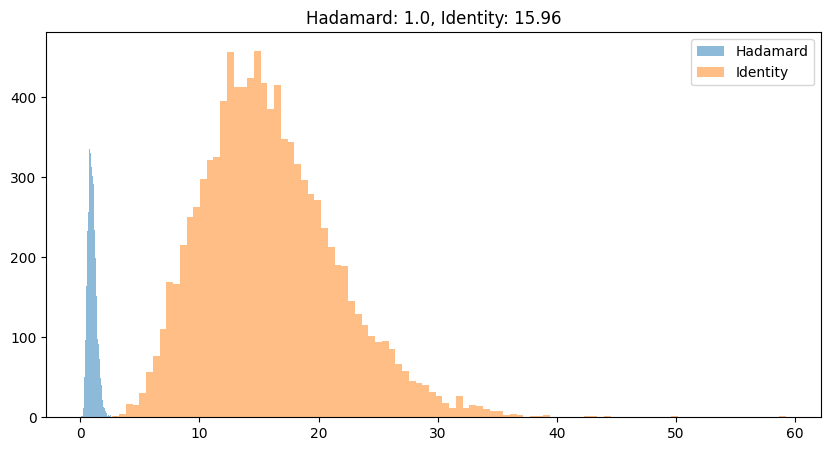

In [17]:
plt.figure(figsize=(10,5))
plt.title("Hadamard: {}, Identity: {}".format(errors_hadamard.mean().round(2), errors_identity.mean().round(2)))
plt.hist(errors_hadamard, bins=100, label="Hadamard", alpha=0.5)
plt.hist(errors_identity, bins=100, label="Identity", alpha=0.5)
plt.legend()
plt.show()

#### **Question:**
1. (a) What are the expected sums of squared differences between estimated and true object weights for the OFAT and combinatorial method in the case of 16 objects?

   
   
### **2. One-factor-at-a-time Method** <a class="anchor" id="one-factor-at-time-method"></a>
Now, we implement the standard OFAT method for multiple factors and levels. Therefore, we consider the factors $x_1, \dots, x_D$, where each factor has a finite number of levels, i.e., $x_d \in \{0, \dots, L_d-1\}, L_d \in \mathbb{N}_{>0}, d \in \{1, \dots, D\}$, where $x_1 = \dots = x_D = 0$ is defined as standard condition without loss of generality.

2. (a) How many conditions, i.e., the number of rows in the design matrix, will be generated by a standard OFAT method at maximum?

   TODO
   
We need to implement the corresponding function [`one_factor_at_a_time`](../e2ml/experimentation/_one_factor_at_a_time.py) in the [`e2ml.experimentation`](../e2ml/experimentation) subpackage.
Once, the implementation has been completed, we check our implementation's validity. 

In [27]:
from e2ml.experimentation import one_factor_at_a_time

levels = [2, 3, 4]

# Obtain the design matrix `X` for the given levels.
X = one_factor_at_a_time(levels=levels)

assert X.shape[0] == 7, "The number of conditions is wrong."
assert X.shape[1] == 3, "The number of factors is wrong."
assert ~(((X > 0).sum(axis=-1) > 1).any()), "There is one row with more than one change factor."
for l_idx, l in enumerate(levels):
    assert np.array_equal(np.unique(X[:, l_idx]), np.arange(l)), f"No all levels were tested of factor {l_idx}."

In [28]:
X

array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 2, 0],
       [0, 0, 1],
       [0, 0, 2],
       [0, 0, 3]])

Once we have implemented and tested our OFAT function, we apply it to a black-box experiment via the function `black_box_data_generation`. In total, there are
$D=4$ factors with $L_1 = 20, L_2 = 4, L_3 = 20, L_4 = 5$. For these factors, we generate a design matrix $\mathbf{X}$ according to a full OFAT method and obtain the corresponding measurements. The goal is to find a condition maximizing the response of the experiment.

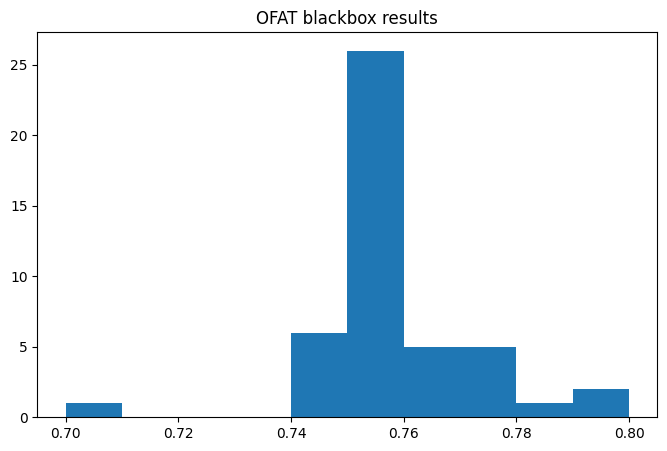

[5 0 0 0] is the condition with the best score (0.8)


In [30]:
# Generate levels according to the black-box experiment.
levels = [20, 4, 20, 5]

# Obtain the design matrix `X` for the given levels.
X = one_factor_at_a_time(levels=levels)

# Perform experimental trials for the given matrix `X` and save the results `res`.
measurements = black_box_data_generation(X)

# Plot the obtained results as a histogram.
plt.figure(figsize=(8,5))
plt.title("OFAT blackbox results")
plt.hist(measurements)
plt.show()

# Print the best condition and its maximum score.
idx_max_measurements = measurements.argmax()
print("{} is the condition with the best score ({})".format(X[idx_max_measurements], measurements[idx_max_measurements]))

### **3. Own Idea of a DoE Method** <a class="anchor" id="own-idea-of-a-doe-method"></a>
A substantial disadvantage of the OFAT method is that it ignores any interactions between varying levels of factors. Therefore, we aim to implement an own DoE method `own_doe_method`, which advances the OFAT method. The DOE method should allow restricting the number of conditions to a user-defined value. Implement and compare your method with the results of OFAT, when using the same number of experimental trials.

In [ ]:
# Implement `own_doe_method` taking `levels` as input.
# TODO als Hausaufgabe
def own_doe_method(levels):
    X = np.zeros(levels.sum())

    return X

# Obtain the design matrix `X` for the given levels.
# TODO

# Perform experimental trials for the given matrix `X` and save the results `res`.
# TODO

# Plot the obtained results as a histogram.
# TODO

# Print the best condition and its maximum score.
# TODO
